In [76]:
"""
This file tests the running time of the linprog algorithm in scipy.optimize.

Tests the special case where the target function is unbounded, so that the algorithm only
returns True if the constraints are consistent (exists a point that satisfies all constraints)
"""
from scipy.optimize import linprog
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", message="Ill-conditioned matrix ")

In [100]:
"""
Given n points' coordinates in d dimensional Euclidean space, considering their patterns,
treat each point-pattern pair as an inequality constraint.
...except for the first point, which is treated as an equality constraint. (This construct is arbitrary, for some secret reason)

Outputs the running time, as well as the linprog messages for debugging.
"""
def linprog_solve(coordinates, patterns, n, d, homogeneous=False, debug=False):
    
    
    non_redundant_pts = []
    if debug: debug_info = [[],[]]
    
    if not homogeneous:
        coordinates_signed = list(map(lambda x: np.append(x,[-1]), coordinates))
    else:
        coordinates_signed = coordinates
    coordinates_signed = list(map(lambda x,y:x*y, np.array(coordinates_signed), patterns))
    
    
    # linear progamming, but sets parameters such that we essentially only deal with a constrained linear system
    def is_non_redundant(i):
        
        c = coordinates_signed[i]
        A = np.array(coordinates_signed[:i] + coordinates_signed[i+1:])
        b = [0] * (n-1)
        
        # we include epsilon, a wiggle room, since we want to exclude the points that are "weakly optimal"
        # meaning in dual space this kind of hyperplane do not form a face of the d-cell
        # but instead, they intersect the d-cell only on a vertex (in R2) or edge (in R3), etc
        epsilon = min(abs(c))/100 if min(abs(c)) > 0 else 0.001
        
        
        res = linprog(np.zeros(len(c)), A_ub=A, b_ub=b, A_eq=c.reshape(1,len(c)), b_eq=[epsilon], bounds=(None, None),
                     method='interior-point', options={'lstsq':True, 'disp':False})
        res2 = linprog(np.zeros(len(c)), A_ub=A, b_ub=b, A_eq=c.reshape(1,len(c)), b_eq=[-epsilon], bounds=(None, None),
                     method='interior-point', options={'lstsq':True, 'disp':False})
        
        if debug: 
            debug_info[0].append(res['message'])
            debug_info[1].append(res2['message'])
        
        return res['success'] and res2['success']
    
    start = time.time()
    is_non_redundant(0)
    end = time.time()
    
    if debug:
        for i in range(1):
            print(coordinates[i], debug_info[0][i], debug_info[1][i])
            
    return end - start

In [101]:
"""
Generates n random points in d dimensions, returns: coordinates,patterns where each is a list
"""
def generate_points(n, d, scale=1):
    
    # generates coordinates
    coordinates = np.array([np.random.uniform(-1,1,d) for i in range(n)])
    # normalize to unit length
    norm_squared = np.array(list(map(lambda x: sum(np.square(x)), coordinates)))
    coordinates = map(lambda x, y: scale ** 2 * np.array([x[i]/(y ** 0.5) for i in range(d)]), coordinates, norm_squared)
    coordinates = np.array(list(coordinates))
    
    # generates patterns
    normal_vec = np.random.uniform(-1,1,d)
    patterns = [1 if np.dot(coordinates[i], normal_vec) > 0 else -1 for i in range(n)]
    
    return coordinates, patterns

In [102]:
"""
Records duration returned by linprog_solve for each output of generate_points
N is an array of n's. D is an array of d's
"""
def time_linprog(N, D, debug=False):
    
    durations = []
    
    for n,d in zip(N,D):  
        coordinates, patterns = generate_points(n,d)
        
        if debug: 
            print(coordinates, patterns)
        
        durations.append(linprog_solve(coordinates, patterns, n, d))
    
    return durations

In [103]:
N = [5 * i for i in range(1,201)]
D = [3] * 201

durations = time_linprog(N,D)

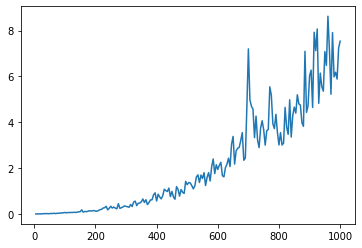

In [104]:
_ = plt.plot(N,durations) # looks like linprog might be polynomial in the number of points, more tests below

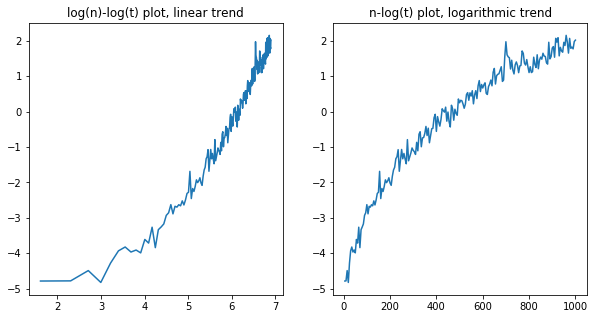

In [116]:
# linear trend in log(n)-log(t) plot + log trend in n-log(t) plot verify that lonprog is indeed polynomial wrt n
durations_diff = [math.log(durations[i]) for i in range(200)]
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
_ = ax1.plot(np.log(N), durations_diff)
_ = plt.title('log(n)-log(t) plot, linear trend')
ax2 = fig.add_subplot(122)
_ = ax2.plot(N, durations_diff)
_ = plt.title('n-log(t) plot, logarithmic trend')

In [114]:
N2 = [10] * 100
D2 = list(range(2,102))

durations_d = time_linprog(N2,D2)

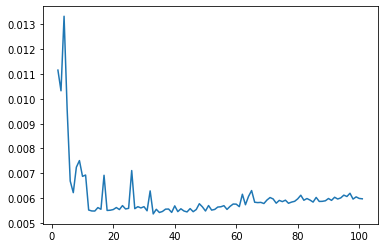

In [117]:
_ = plt.plot(D2, durations_d) # and constant wrt dimensions d

In [ ]:
"""Final Notes:

First of all, from scipy documentation:
    https://docs.scipy.org/doc/scipy/reference/optimize.linprog-interior-point.html
========================================================================================================
    solvers are tried in the following order:

    1. scipy.linalg.cho_factor
    2. scipy.linalg.solve with option sym_pos=True
    3. scipy.linalg.solve with option sym_pos=False
    4. scipy.linalg.lstsq

    If the solver fails for any reason, successively more robust (but slower) solvers are attempted in the order indicated. 
    Attempting, failing, and re-starting factorization can be time consuming, so if the problem is numerically challenging, 
    options can be set to bypass solvers that are failing. Setting cholesky=False skips to solver 2, sym_pos=False skips to 
    solver 3, and lstsq=True skips to solver 4 for both sparse and dense problems.
========================================================================================================

Second, if you read the documentation above, you can see that trying solvers one-by-one will speed up certain problems, but
cause noise in the running time estimation we were trying to perform. As a result, the test in this file directly tells the
solver to skip to step 4 for the most robust (and probably the slowest) method. And since the lstsq method runs in polynomial
time, we have verified that the common knowledge about the theoretical polynomial running time of linear programming algo is
indeed achieved by scipy.optimize.linprog.
"""